In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import re
import pickle
from matplotlib import pyplot as plt
import sklearn
from sklearn import datasets, neighbors, linear_model, model_selection, svm
from sklearn.model_selection import train_test_split,KFold,learning_curve, LeavePOut,GridSearchCV

%matplotlib inline

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.utils as utils

## Feature Extraction

### Load Existing Data

In [3]:
def load_data(pickle_file):
    data = pd.read_pickle(pickle_file)
    # Split the data into training set and test set.
    # DONT look at what is in the test set
    test_data = data.loc[utils.TEST_KEYS]
    train_data = data.loc[data.index.difference(utils.TEST_KEYS)]
    return train_data, test_data

In [4]:
# Try each thing separately - concat, difference and dimension reduction.
train_inception_concat, test_inception_concat = load_data('data_inception_cnn_concat.pkl')
train_inception_diff, test_inception_diff = load_data('data_inception_cnn_diff.pkl')
train_reduced_dim, test_reduced_dim = load_data("data_inception_cnn_diff_reduced_dim.pkl")

# Difference before normalizing. Includes data augmentation
train_reduced_dim_aug, test_reduced_dim_aug = load_data("data_inception_cnn_diff_reduced_dim_augmented.pkl")

# Normalized before the difference
train_reduced_dim_aug2, test_reduced_dim_aug2 = load_data("data_norm_inception_cnn_diff_reduced_dim_augmented.pkl")

#### Baseline

This baseline builds a feature set by pulling pairs of images and creating a difference of the image histograms they produce. The assumption is that files are contained in some input directory in the form patientX-1.jpg, patientX-2.jpg

In [5]:
X_concat = train_inception_concat.drop('y', axis=1)
y_concat = train_inception_concat["y"]

X_diff = train_inception_diff.drop('y', axis=1)
y_diff = train_inception_diff["y"]

X_reduced = train_reduced_dim.drop('y', axis=1)
y_reduced = train_reduced_dim["y"]

X_reduced_aug = train_reduced_dim_aug.drop('y', axis=1)
y_reduced_aug = train_reduced_dim_aug["y"]

X_reduced_aug2 = train_reduced_dim_aug2.drop('y', axis=1)
y_reduced_aug2 = train_reduced_dim_aug2["y"]

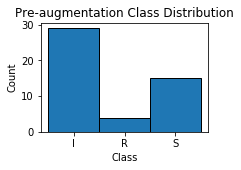

In [43]:
# Plot distribution of datapoints
# Suvadip suggested trying a binary classifier by combining regressed and persistent into one class.
# Then use ROC curve (used in binary classification) to evaluate model

csfont = {'fontname':'Times New Roman'}
plt.title('Pre-augmentation Class Distribution', **csfont)
plt.xlabel('Class')
plt.ylabel('Count')
fig = plt.gcf()
fig.set_size_inches(3, 2)
ind = np.arange(3)
plt.hist(y_diff.tolist(),bins=np.arange(4)-0.5, ec="k")
plt.show()

In [45]:
# This is based on recommendation from Suvadip. Leave one out is used for VERY small samples (size 15-20)
lpo = LeavePOut(3)

### KNN Classifier

In [6]:
def train_knn(X, y, multiclass, cv=LeavePOut(3), test_size=0.3):
    params = [{'n_neighbors': [2,3,4,5,6]}]
    knn = GridSearchCV(neighbors.KNeighborsClassifier(), cv=cv, param_grid = params)
    utils.do_CV(X,y, knn, multi_class=multiclass, test_size=test_size)
    return knn.best_estimator_

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.571 (+/-0.221) for {'n_neighbors': 2}
0.554 (+/-0.254) for {'n_neighbors': 3}
0.518 (+/-0.176) for {'n_neighbors': 4}
0.518 (+/-0.322) for {'n_neighbors': 5}
0.518 (+/-0.322) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


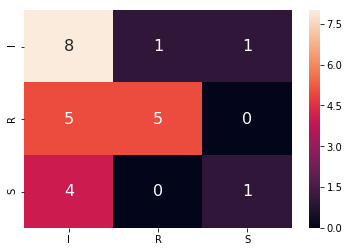

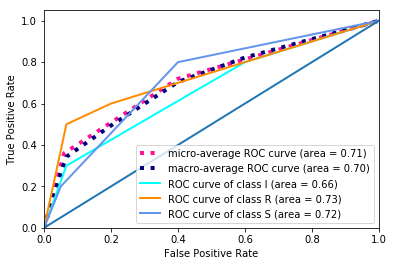


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.47      0.80      0.59        10
           R       0.83      0.50      0.62        10
           S       0.50      0.20      0.29         5

   micro avg       0.56      0.56      0.56        25
   macro avg       0.60      0.50      0.50        25
weighted avg       0.62      0.56      0.54        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.77      1.00      0.87        23
           R       0.86      0.78      0.82        23
           S       1.00      0.50      0.67        10

   micro avg       0.82      0.82      0.82        56
   macro avg       0.87      0.76      0.78        56
weighted avg       0.85      0.82      0.81        56



In [47]:
knn_model = train_knn(X_reduced_aug2, y_reduced_aug2, multiclass=True, cv=5, test_size=0.3)
pickle.dump(knn_model, open("knn_model_multi.pkl", "wb"))

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.576 (+/-0.266) for {'n_neighbors': 2}
0.545 (+/-0.198) for {'n_neighbors': 3}
0.545 (+/-0.292) for {'n_neighbors': 4}
0.485 (+/-0.229) for {'n_neighbors': 5}
0.545 (+/-0.158) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


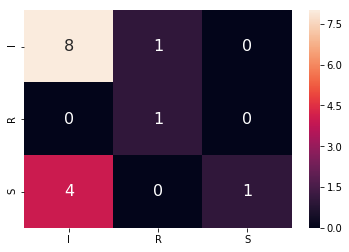

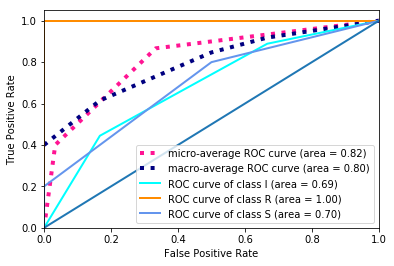


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.67      0.89      0.76         9
           R       0.50      1.00      0.67         1
           S       1.00      0.20      0.33         5

   micro avg       0.67      0.67      0.67        15
   macro avg       0.72      0.70      0.59        15
weighted avg       0.77      0.67      0.61        15

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.77      1.00      0.87        20
           R       1.00      0.67      0.80         3
           S       1.00      0.50      0.67        10

   micro avg       0.82      0.82      0.82        33
   macro avg       0.92      0.72      0.78        33
weighted avg       0.86      0.82      0.80        33



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [11]:
train_knn(X_reduced, y_reduced, True, cv=5)

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.606 (+/-0.221) for {'n_neighbors': 2}
0.515 (+/-0.180) for {'n_neighbors': 3}
0.576 (+/-0.355) for {'n_neighbors': 4}
0.515 (+/-0.384) for {'n_neighbors': 5}
0.606 (+/-0.207) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


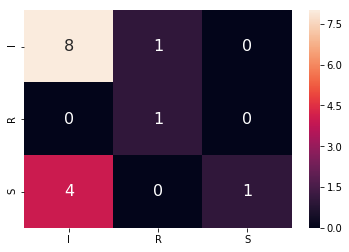

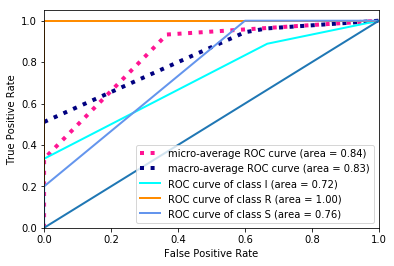


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.67      0.89      0.76         9
           R       0.50      1.00      0.67         1
           S       1.00      0.20      0.33         5

   micro avg       0.67      0.67      0.67        15
   macro avg       0.72      0.70      0.59        15
weighted avg       0.77      0.67      0.61        15

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.80      1.00      0.89        20
           R       1.00      0.67      0.80         3
           S       1.00      0.60      0.75        10

   micro avg       0.85      0.85      0.85        33
   macro avg       0.93      0.76      0.81        33
weighted avg       0.88      0.85      0.84        33



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [12]:
train_knn(X_diff, y_diff, True, cv=5)

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.515 (+/-0.295) for {'n_neighbors': 2}
0.394 (+/-0.207) for {'n_neighbors': 3}
0.485 (+/-0.180) for {'n_neighbors': 4}
0.424 (+/-0.255) for {'n_neighbors': 5}
0.485 (+/-0.180) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


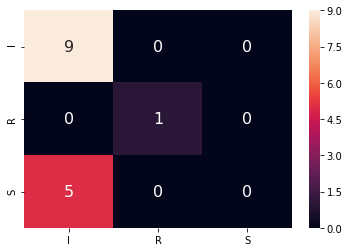

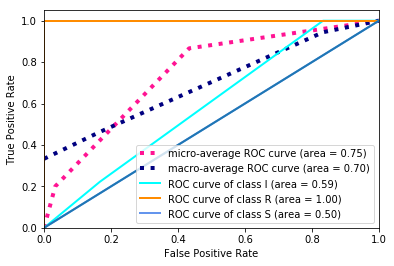


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.64      1.00      0.78         9
           R       1.00      1.00      1.00         1
           S       0.00      0.00      0.00         5

   micro avg       0.67      0.67      0.67        15
   macro avg       0.55      0.67      0.59        15
weighted avg       0.45      0.67      0.54        15

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.74      1.00      0.85        20
           R       1.00      0.67      0.80         3
           S       1.00      0.40      0.57        10

   micro avg       0.79      0.79      0.79        33
   macro avg       0.91      0.69      0.74        33
weighted avg       0.84      0.79      0.76        33



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
train_knn(X_concat, y_concat, True, cv=5)

### KNN binary

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.661 (+/-0.242) for {'n_neighbors': 2}
0.786 (+/-0.280) for {'n_neighbors': 3}
0.696 (+/-0.156) for {'n_neighbors': 4}
0.679 (+/-0.251) for {'n_neighbors': 5}
0.696 (+/-0.227) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


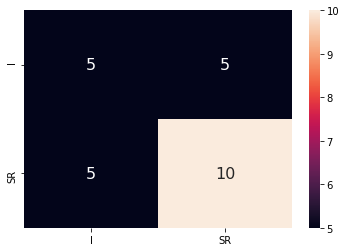

ROC AUC score
0.616666666667


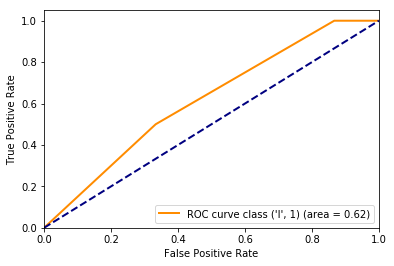


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.50      0.50      0.50        10
          SR       0.67      0.67      0.67        15

   micro avg       0.60      0.60      0.60        25
   macro avg       0.58      0.58      0.58        25
weighted avg       0.60      0.60      0.60        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.95      0.91      0.93        23
          SR       0.94      0.97      0.96        33

   micro avg       0.95      0.95      0.95        56
   macro avg       0.95      0.94      0.94        56
weighted avg       0.95      0.95      0.95        56



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [30]:
train_knn(X_reduced_aug2, y_reduced_aug2, multiclass=False, cv=5, test_size=0.3) # BAD MODEL

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.607 (+/-0.273) for {'n_neighbors': 2}
0.786 (+/-0.269) for {'n_neighbors': 3}
0.679 (+/-0.256) for {'n_neighbors': 4}
0.714 (+/-0.300) for {'n_neighbors': 5}
0.661 (+/-0.313) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


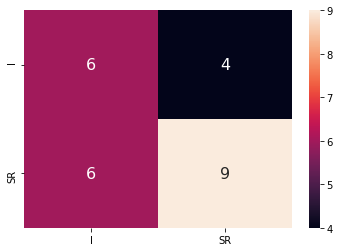

ROC AUC score
0.606666666667


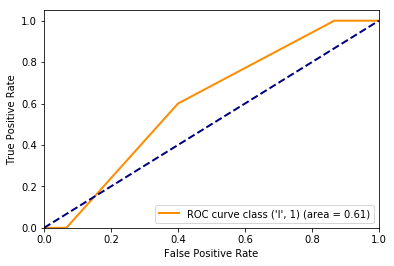


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.50      0.60      0.55        10
          SR       0.69      0.60      0.64        15

   micro avg       0.60      0.60      0.60        25
   macro avg       0.60      0.60      0.59        25
weighted avg       0.62      0.60      0.60        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.94      0.74      0.83        23
          SR       0.84      0.97      0.90        33

   micro avg       0.88      0.88      0.88        56
   macro avg       0.89      0.85      0.87        56
weighted avg       0.88      0.88      0.87        56



In [25]:
knn_binary = train_knn(X_reduced_aug, y_reduced_aug, False, cv=5)
pickle.dump(knn_binary, open("knn_model_binary.pkl", "wb"))

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.606 (+/-0.303) for {'n_neighbors': 2}
0.515 (+/-0.395) for {'n_neighbors': 3}
0.485 (+/-0.229) for {'n_neighbors': 4}
0.485 (+/-0.384) for {'n_neighbors': 5}
0.515 (+/-0.229) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



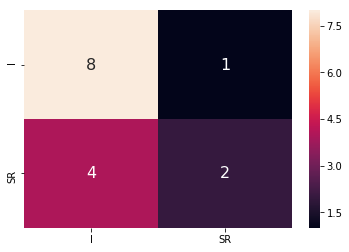

ROC AUC score
0.611111111111


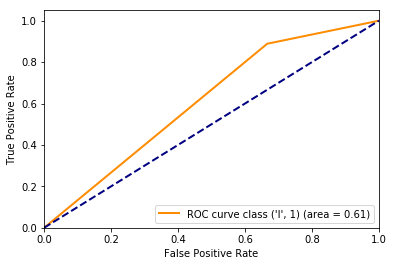


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.67      0.89      0.76         9
         SR       0.67      0.33      0.44         6

avg / total       0.67      0.67      0.63        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.80      1.00      0.89        20
         SR       1.00      0.62      0.76        13

avg / total       0.88      0.85      0.84        33



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [122]:
# extra reduced
train_knn(X_reduced, y_reduced, False, cv=5)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.606 (+/-0.303) for {'n_neighbors': 2}
0.515 (+/-0.395) for {'n_neighbors': 3}
0.485 (+/-0.229) for {'n_neighbors': 4}
0.485 (+/-0.384) for {'n_neighbors': 5}
0.515 (+/-0.229) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



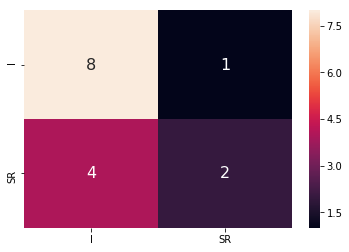

ROC AUC score
0.611111111111


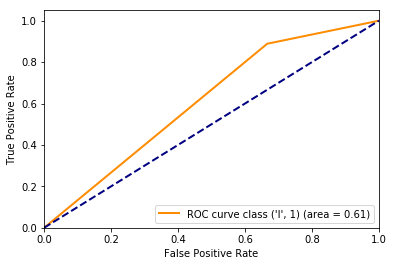


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.67      0.89      0.76         9
         SR       0.67      0.33      0.44         6

avg / total       0.67      0.67      0.63        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.80      1.00      0.89        20
         SR       1.00      0.62      0.76        13

avg / total       0.88      0.85      0.84        33



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [123]:
train_knn(X_reduced, y_reduced, False, cv=5)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.697 (+/-0.192) for {'n_neighbors': 2}
0.606 (+/-0.383) for {'n_neighbors': 3}
0.636 (+/-0.394) for {'n_neighbors': 4}
0.545 (+/-0.282) for {'n_neighbors': 5}
0.576 (+/-0.212) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



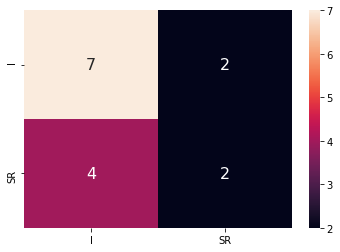

ROC AUC score
0.601851851852


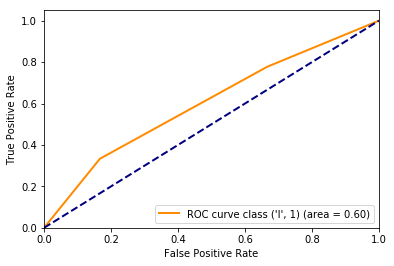


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.64      0.78      0.70         9
         SR       0.50      0.33      0.40         6

avg / total       0.58      0.60      0.58        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.83      1.00      0.91        20
         SR       1.00      0.69      0.82        13

avg / total       0.90      0.88      0.87        33



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [124]:
train_knn(X_diff, y_diff, False, cv=5)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.576 (+/-0.282) for {'n_neighbors': 2}
0.394 (+/-0.322) for {'n_neighbors': 3}
0.455 (+/-0.375) for {'n_neighbors': 4}
0.515 (+/-0.295) for {'n_neighbors': 5}
0.576 (+/-0.101) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


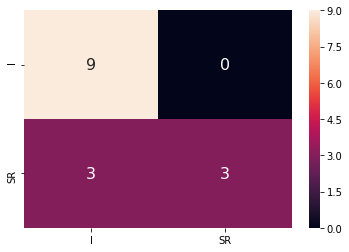

ROC AUC score
0.722222222222


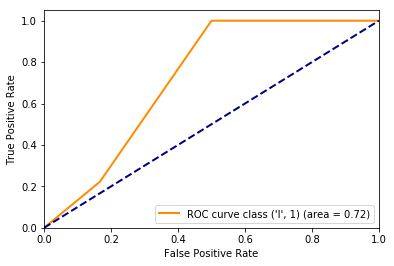


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.75      1.00      0.86         9
          SR       1.00      0.50      0.67         6

   micro avg       0.80      0.80      0.80        15
   macro avg       0.88      0.75      0.76        15
weighted avg       0.85      0.80      0.78        15

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.83      1.00      0.91        20
          SR       1.00      0.69      0.82        13

   micro avg       0.88      0.88      0.88        33
   macro avg       0.92      0.85      0.86        33
weighted avg       0.90      0.88      0.87        33



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [8]:
train_knn(X_concat, y_concat, False, cv=5)

### Logistic Linear

In [9]:
def train_logistic_feature_selection(X,y, multiclass):
    # ALWAYS use regularization because of small data
    params = [{'penalty': ['l2'], 'C': [0.001]}]
    lr = GridSearchCV(linear_model.LogisticRegression(solver='liblinear'), cv=5, param_grid = params)
    if multiclass:
        params = [{'solver':['lbfgs']}]
        lr = GridSearchCV(linear_model.LogisticRegression(multi_class="multinomial", max_iter=3000), cv=5, param_grid = params)
    utils.do_CV(X,y, lr, multi_class=multiclass)
    return lr.best_estimator_

'\n\ntrain_inception_concat, test_inception_concat = load_data(\'data_inception_cnn.pkl\')\ntrain_inception_diff, test_inception_diff = load_data(\'data_inception_cnn_diff.pkl\')\ntrain_reduced_dim, test_reduced_dim = load_data("data_inception_cnn_diff_reduced_dim.pkl")\n'

In [19]:
def train_logistic(X,y, multiclass, cv=5, test_size=0.3, scoring="accuracy"):
    # ALWAYS use regularization because of small data
    params = [{'penalty': ['l1','l2'], 'C': [0.00001,0.00005,0.0001,0.001,0.01, 0.05]}]
    lr = GridSearchCV(linear_model.LogisticRegression(solver='liblinear', max_iter=30000),
                      cv=cv, param_grid = params, scoring=scoring)
    if multiclass:
        params = [{'solver':['lbfgs'],'penalty':['l2'],'C': [0.00001,0.00005,0.0001,0.001,0.01, 0.05, 0.1]}]
        lr = GridSearchCV(linear_model.LogisticRegression(multi_class="multinomial", max_iter=30000), cv=cv, param_grid = params, scoring=scoring)
    utils.do_CV(X,y, lr, multi_class=multiclass, test_size=test_size)
    return lr.best_estimator_

In [8]:
from sklearn.metrics import f1_score, make_scorer
f1_multi_scorer = make_scorer(f1_score, labels=['I', 'R', 'S'], average="weighted")
f1_bi_scorer = make_scorer(f1_score, labels=['I', 'SR'], pos_label='I', average="binary")

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'penalty': 'l2', 'C': 0.05}

Grid scores on development set:

0.582 (+/-0.049) for {'penalty': 'l1', 'C': 1e-05}
0.738 (+/-0.209) for {'penalty': 'l2', 'C': 1e-05}
0.582 (+/-0.049) for {'penalty': 'l1', 'C': 5e-05}
0.738 (+/-0.209) for {'penalty': 'l2', 'C': 5e-05}
0.582 (+/-0.049) for {'penalty': 'l1', 'C': 0.0001}
0.738 (+/-0.209) for {'penalty': 'l2', 'C': 0.0001}
0.582 (+/-0.049) for {'penalty': 'l1', 'C': 0.001}
0.738 (+/-0.209) for {'penalty': 'l2', 'C': 0.001}
0.582 (+/-0.049) for {'penalty': 'l1', 'C': 0.01}
0.748 (+/-0.185) for {'penalty': 'l2', 'C': 0.01}
0.582 (+/-0.049) for {'penalty': 'l1', 'C': 0.05}
0.819 (+/-0.236) for {'penalty': 'l2', 'C': 0.05}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



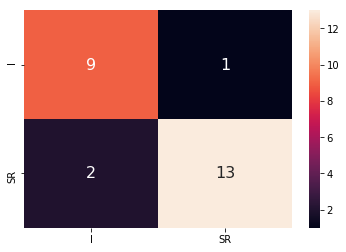

ROC AUC score
0.92


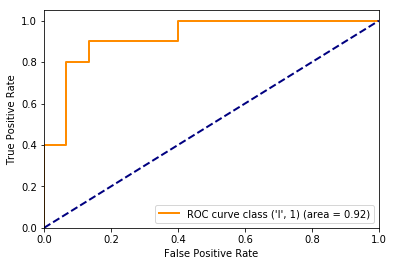


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.82      0.90      0.86        10
          SR       0.93      0.87      0.90        15

   micro avg       0.88      0.88      0.88        25
   macro avg       0.87      0.88      0.88        25
weighted avg       0.88      0.88      0.88        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.92      0.96      0.94        23
          SR       0.97      0.94      0.95        33

   micro avg       0.95      0.95      0.95        56
   macro avg       0.94      0.95      0.95        56
weighted avg       0.95      0.95      0.95        56



In [9]:
lr2 = train_logistic(X_reduced_aug2, y_reduced_aug2, False, cv=6, test_size=0.3, scoring=f1_bi_scorer)
#pickle.dump(lr2, open("lr2_binary_norm_reduced_model_aug_f1.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.05, 'penalty': 'l2'}

Grid scores on development set:

0.411 (+/-0.049) for {'C': 0.001, 'penalty': 'l1'}
0.786 (+/-0.220) for {'C': 0.001, 'penalty': 'l2'}
0.411 (+/-0.049) for {'C': 0.01, 'penalty': 'l1'}
0.804 (+/-0.148) for {'C': 0.01, 'penalty': 'l2'}
0.411 (+/-0.049) for {'C': 0.05, 'penalty': 'l1'}
0.857 (+/-0.201) for {'C': 0.05, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


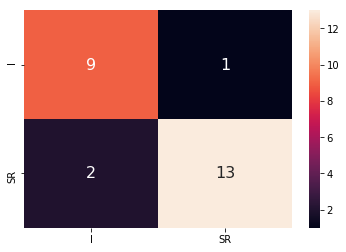

ROC AUC score
0.92


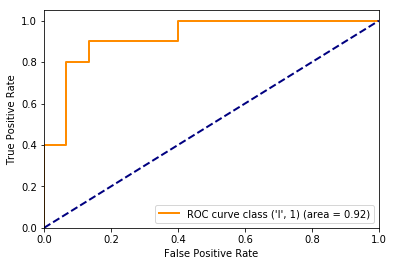


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.82      0.90      0.86        10
          SR       0.93      0.87      0.90        15

   micro avg       0.88      0.88      0.88        25
   macro avg       0.87      0.88      0.88        25
weighted avg       0.88      0.88      0.88        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.92      0.96      0.94        23
          SR       0.97      0.94      0.95        33

   micro avg       0.95      0.95      0.95        56
   macro avg       0.94      0.95      0.95        56
weighted avg       0.95      0.95      0.95        56



In [90]:
lr2 = train_logistic(X_reduced_aug2, y_reduced_aug2, False, cv=6, test_size=0.3)
pickle.dump(lr2, open("lr2_binary_norm_reduced_model_aug.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.05, 'penalty': 'l2'}

Grid scores on development set:

0.406 (+/-0.052) for {'C': 0.001, 'penalty': 'l1'}
0.844 (+/-0.198) for {'C': 0.001, 'penalty': 'l2'}
0.406 (+/-0.052) for {'C': 0.01, 'penalty': 'l1'}
0.875 (+/-0.179) for {'C': 0.01, 'penalty': 'l2'}
0.406 (+/-0.052) for {'C': 0.05, 'penalty': 'l1'}
0.922 (+/-0.156) for {'C': 0.05, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


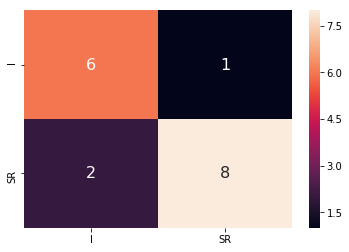

ROC AUC score
0.914285714286


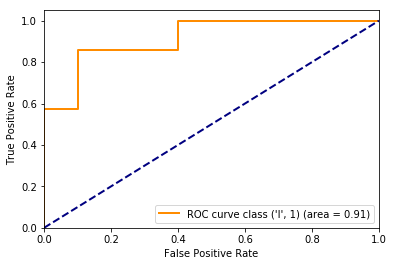


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.75      0.86      0.80         7
          SR       0.89      0.80      0.84        10

   micro avg       0.82      0.82      0.82        17
   macro avg       0.82      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.96      1.00      0.98        26
          SR       1.00      0.97      0.99        38

   micro avg       0.98      0.98      0.98        64
   macro avg       0.98      0.99      0.98        64
weighted avg       0.98      0.98      0.98        64



In [41]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, False, cv=7, test_size=0.2)
pickle.dump(lr, open("lr_binary_reduced_model_aug.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.05, 'penalty': 'l2'}

Grid scores on development set:

0.411 (+/-0.063) for {'C': 0.001, 'penalty': 'l1'}
0.786 (+/-0.215) for {'C': 0.001, 'penalty': 'l2'}
0.411 (+/-0.063) for {'C': 0.01, 'penalty': 'l1'}
0.768 (+/-0.212) for {'C': 0.01, 'penalty': 'l2'}
0.411 (+/-0.063) for {'C': 0.05, 'penalty': 'l1'}
0.821 (+/-0.218) for {'C': 0.05, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


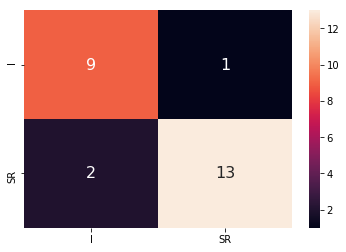

ROC AUC score
0.92


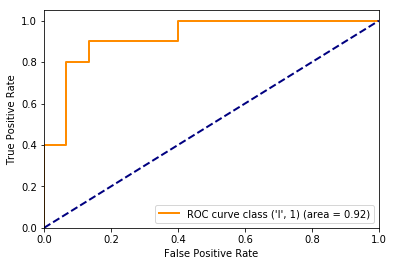


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.82      0.90      0.86        10
          SR       0.93      0.87      0.90        15

   micro avg       0.88      0.88      0.88        25
   macro avg       0.87      0.88      0.88        25
weighted avg       0.88      0.88      0.88        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.92      0.96      0.94        23
          SR       0.97      0.94      0.95        33

   micro avg       0.95      0.95      0.95        56
   macro avg       0.94      0.95      0.95        56
weighted avg       0.95      0.95      0.95        56



In [37]:
lr = train_logistic(X_reduced_aug2, y_reduced_aug2, False, 7)
pickle.dump(lr, open("lr_binary_reduced_model_aug2.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.05, 'penalty': 'l2'}

Grid scores on development set:

0.411 (+/-0.063) for {'C': 0.001, 'penalty': 'l1'}
0.768 (+/-0.202) for {'C': 0.001, 'penalty': 'l2'}
0.411 (+/-0.063) for {'C': 0.01, 'penalty': 'l1'}
0.821 (+/-0.286) for {'C': 0.01, 'penalty': 'l2'}
0.411 (+/-0.063) for {'C': 0.05, 'penalty': 'l1'}
0.893 (+/-0.202) for {'C': 0.05, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


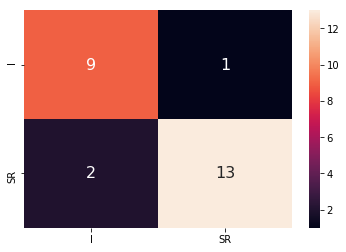

ROC AUC score
0.933333333333


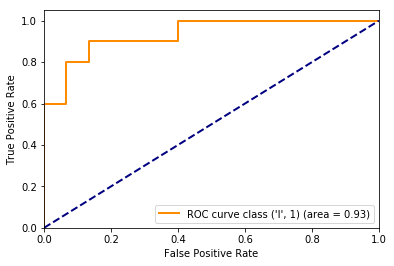


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.82      0.90      0.86        10
          SR       0.93      0.87      0.90        15

   micro avg       0.88      0.88      0.88        25
   macro avg       0.87      0.88      0.88        25
weighted avg       0.88      0.88      0.88        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       1.00      1.00      1.00        23
          SR       1.00      1.00      1.00        33

   micro avg       1.00      1.00      1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



In [36]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, False, 7)
pickle.dump(lr, open("lr_binary_reduced_model_aug2.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.001, 'penalty': 'l1'}

Grid scores on development set:

0.606 (+/-0.061) for {'C': 0.001, 'penalty': 'l1'}
0.606 (+/-0.229) for {'C': 0.001, 'penalty': 'l2'}
0.606 (+/-0.061) for {'C': 0.01, 'penalty': 'l1'}
0.545 (+/-0.298) for {'C': 0.01, 'penalty': 'l2'}
0.606 (+/-0.061) for {'C': 0.05, 'penalty': 'l1'}
0.515 (+/-0.276) for {'C': 0.05, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


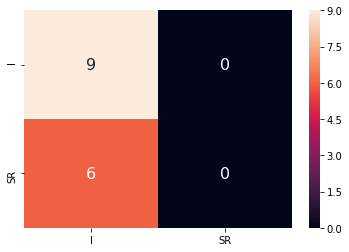

ROC AUC score
0.5


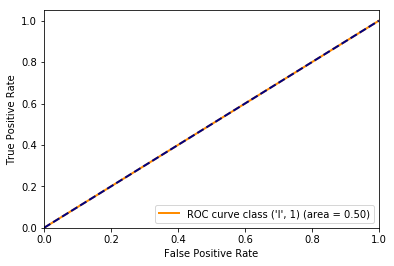


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.60      1.00      0.75         9
          SR       0.00      0.00      0.00         6

   micro avg       0.60      0.60      0.60        15
   macro avg       0.30      0.50      0.37        15
weighted avg       0.36      0.60      0.45        15

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.61      1.00      0.75        20
          SR       0.00      0.00      0.00        13

   micro avg       0.61      0.61      0.61        33
   macro avg       0.30      0.50      0.38        33
weighted avg       0.37      0.61      0.46        33



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

In [16]:
lr = train_logistic(X_reduced, y_reduced, False, cv=6)
pickle.dump(lr, open("lr_binary_reduced_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.001, 'penalty': 'l1'}

Grid scores on development set:

0.606 (+/-0.092) for {'C': 0.001, 'penalty': 'l1'}
0.576 (+/-0.157) for {'C': 0.001, 'penalty': 'l2'}
0.606 (+/-0.092) for {'C': 0.01, 'penalty': 'l1'}
0.545 (+/-0.198) for {'C': 0.01, 'penalty': 'l2'}
0.606 (+/-0.092) for {'C': 0.05, 'penalty': 'l1'}
0.545 (+/-0.307) for {'C': 0.05, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



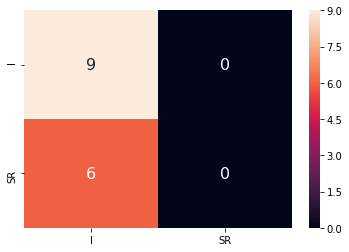

ROC AUC score
0.5


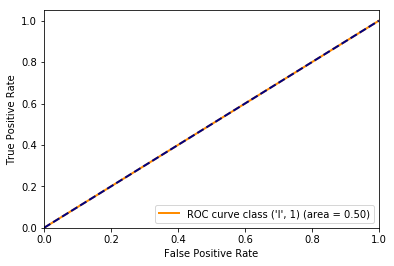


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.60      1.00      0.75         9
         SR       0.00      0.00      0.00         6

avg / total       0.36      0.60      0.45        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.61      1.00      0.75        20
         SR       0.00      0.00      0.00        13

avg / total       0.37      0.61      0.46        33



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [152]:
lr = train_logistic(X_diff, y_diff, False)
pickle.dump(lr, open("lr_binary_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.01, 'penalty': 'l2'}

Grid scores on development set:

0.606 (+/-0.092) for {'C': 0.001, 'penalty': 'l1'}
0.606 (+/-0.092) for {'C': 0.001, 'penalty': 'l2'}
0.606 (+/-0.092) for {'C': 0.01, 'penalty': 'l1'}
0.697 (+/-0.226) for {'C': 0.01, 'penalty': 'l2'}
0.606 (+/-0.092) for {'C': 0.05, 'penalty': 'l1'}
0.697 (+/-0.375) for {'C': 0.05, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



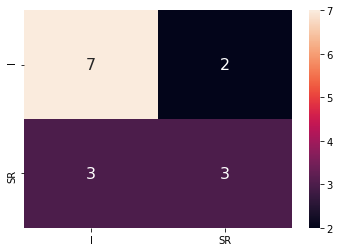

ROC AUC score
0.722222222222


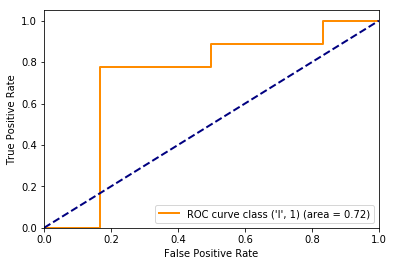


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.70      0.78      0.74         9
         SR       0.60      0.50      0.55         6

avg / total       0.66      0.67      0.66        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.83      1.00      0.91        20
         SR       1.00      0.69      0.82        13

avg / total       0.90      0.88      0.87        33



In [153]:
lr = train_logistic(X_concat, y_concat, False)
pickle.dump(lr, open("lr_binary_concat_model.pkl", "wb") )

### Logistic multiclass model

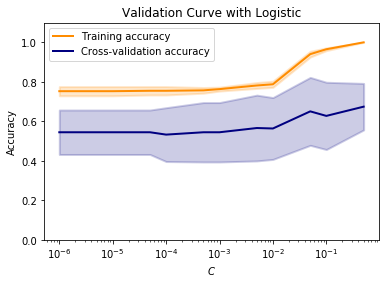

In [50]:
param_range = np.array([0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001, 0.005,0.01,0.05, 0.1,0.5])
#lr = GridSearchCV(linear_model.LogisticRegression(solver='liblinear'), cv=cv, param_grid = params, scoring=scoring)

lr2 = linear_model.LogisticRegression(solver='lbfgs', penalty='l2', multi_class="multinomial", max_iter=3000)
   
utils.generate_validation_curve(lr2, X_reduced_aug2, y_reduced_aug2, param_name="C", param_range=param_range,
                                cv=7, scoring="accuracy", n_jobs=-1,
                                title="Validation Curve with Logistic", xlabel="$C$")

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted',

Best parameters set found on development set:

{'penalty': 'l2', 'C': 0.5, 'solver': 'lbfgs'}

Grid scores on development set:

0.598 (+/-0.258) for {'penalty': 'l2', 'C': 1e-05, 'solver': 'lbfgs'}
0.598 (+/-0.258) for {'penalty': 'l2', 'C': 5e-05, 'solver': 'lbfgs'}
0.598 (+/-0.258) for {'penalty': 'l2', 'C': 0.0001, 'solver': 'lbfgs'}
0.598 (+/-0.258) for {'penalty': 'l2', 'C': 0.001, 'solver': 'lbfgs'}
0.630 (+/-0.151) for {'penalty': 'l2', 'C': 0.01, 'solver': 'lbfgs'}
0.683 (+/-0.214) for {'penalty': 'l2', 'C': 0.05, 'solver': 'lbfgs'}
0.706 (+/-0.201) for {'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs'}
0.789 (+/-0.120) for {'penalty': 'l2', 'C': 0.5, 'solver': 'lbfgs'}
0.775 (+/-0.111) for {'penalty': 'l2', 'C': 1, 'solver': 'lbfgs'}
0.754 (+/-0.153) for {'penalty': 'l2', 'C': 10, 'solver': 'lbfgs'}
0.742 (+/-0.188) for {'penalty': 'l2', 'C': 100, 'solver': 'lbfgs'}
0.742 (+/-0.188) for {'penalty': 'l2', 'C': 1000, 'solver': 'lbfgs'}

Detailed classification report:

The model is 

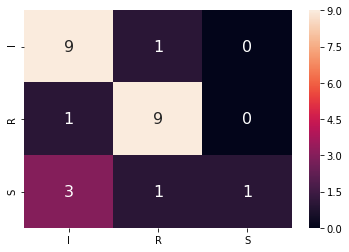

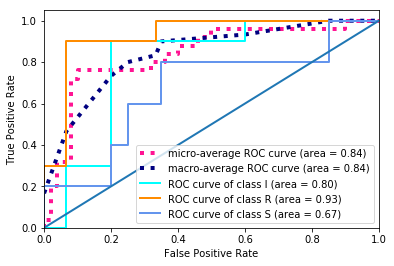


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.69      0.90      0.78        10
           R       0.82      0.90      0.86        10
           S       1.00      0.20      0.33         5

   micro avg       0.76      0.76      0.76        25
   macro avg       0.84      0.67      0.66        25
weighted avg       0.80      0.76      0.72        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       1.00      1.00      1.00        23
           R       1.00      1.00      1.00        23
           S       1.00      1.00      1.00        10

   micro avg       1.00      1.00      1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



In [17]:
lr = train_logistic(X_reduced_aug2, y_reduced_aug2, True, cv=5, test_size=0.3, scoring=f1_multi_scorer)
pickle.dump(lr, open("lr2_multi_norm_aug_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'penalty': 'l2', 'C': 0.05, 'solver': 'lbfgs'}

Grid scores on development set:

0.714 (+/-0.192) for {'penalty': 'l2', 'C': 1e-05, 'solver': 'lbfgs'}
0.714 (+/-0.192) for {'penalty': 'l2', 'C': 5e-05, 'solver': 'lbfgs'}
0.714 (+/-0.192) for {'penalty': 'l2', 'C': 0.0001, 'solver': 'lbfgs'}
0.714 (+/-0.192) for {'penalty': 'l2', 'C': 0.001, 'solver': 'lbfgs'}
0.732 (+/-0.162) for {'penalty': 'l2', 'C': 0.01, 'solver': 'lbfgs'}
0.821 (+/-0.181) for {'penalty': 'l2', 'C': 0.05, 'solver': 'lbfgs'}
0.821 (+/-0.181) for {'penalty': 'l2', 'C': 0.1, 'solver': 'lbfgs'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


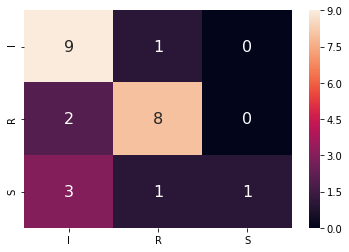

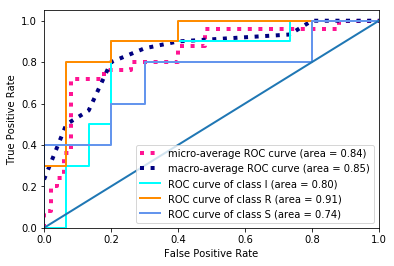


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.64      0.90      0.75        10
           R       0.80      0.80      0.80        10
           S       1.00      0.20      0.33         5

   micro avg       0.72      0.72      0.72        25
   macro avg       0.81      0.63      0.63        25
weighted avg       0.78      0.72      0.69        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.96      1.00      0.98        23
           R       0.92      1.00      0.96        23
           S       1.00      0.70      0.82        10

   micro avg       0.95      0.95      0.95        56
   macro avg       0.96      0.90      0.92        56
weighted avg       0.95      0.95      0.94        56



In [20]:
lr = train_logistic(X_reduced_aug2, y_reduced_aug2, True, cv=6, test_size=0.3)
pickle.dump(lr, open("lr2_multi_norm_aug_model.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.688 (+/-0.210) for {'C': 0.001}
0.719 (+/-0.132) for {'C': 0.01}
0.719 (+/-0.173) for {'C': 0.05}
0.734 (+/-0.182) for {'C': 0.1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


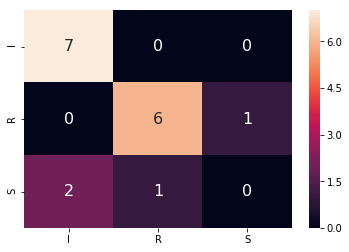

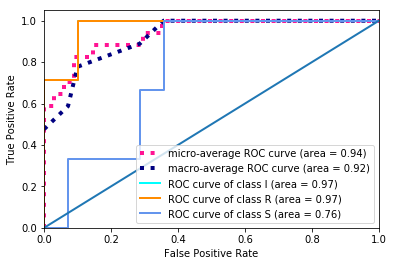


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.78      1.00      0.88         7
           R       0.86      0.86      0.86         7
           S       0.00      0.00      0.00         3

   micro avg       0.76      0.76      0.76        17
   macro avg       0.54      0.62      0.58        17
weighted avg       0.67      0.76      0.71        17

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.96      1.00      0.98        26
           R       1.00      1.00      1.00        26
           S       1.00      0.92      0.96        12

   micro avg       0.98      0.98      0.98        64
   macro avg       0.99      0.97      0.98        64
weighted avg       0.98      0.98      0.98        64



In [39]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, True, cv=7, test_size=0.2)
pickle.dump(lr, open("lr_multi_reduced_model_aug.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.05}

Grid scores on development set:

0.676 (+/-0.138) for {'C': 0.001}
0.735 (+/-0.141) for {'C': 0.01}
0.750 (+/-0.191) for {'C': 0.05}
0.735 (+/-0.189) for {'C': 0.1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


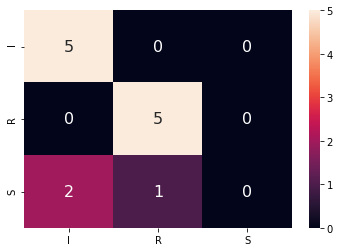

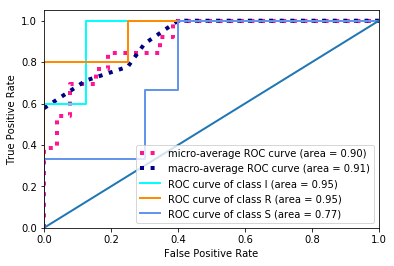


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.71      1.00      0.83         5
           R       0.83      1.00      0.91         5
           S       0.00      0.00      0.00         3

   micro avg       0.77      0.77      0.77        13
   macro avg       0.52      0.67      0.58        13
weighted avg       0.60      0.77      0.67        13

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.97      1.00      0.98        28
           R       1.00      1.00      1.00        28
           S       1.00      0.92      0.96        12

   micro avg       0.99      0.99      0.99        68
   macro avg       0.99      0.97      0.98        68
weighted avg       0.99      0.99      0.99        68



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, True, cv=5, test_size=0.15)
pickle.dump(lr, open("lr_multi_reduced_model_aug_strat.pkl", "wb") )

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=7.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=7.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=7.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warn

Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.606 (+/-0.237) for {'C': 0.001}
0.606 (+/-0.409) for {'C': 0.01}
0.636 (+/-0.385) for {'C': 0.05}
0.667 (+/-0.246) for {'C': 0.1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



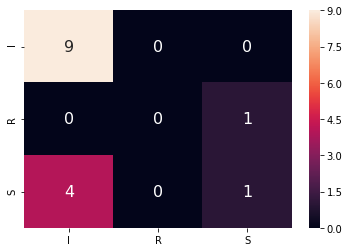

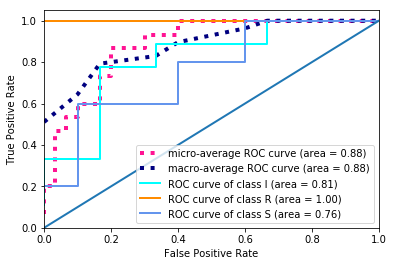


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.69      1.00      0.82         9
          R       0.00      0.00      0.00         1
          S       0.50      0.20      0.29         5

avg / total       0.58      0.67      0.59        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        20
          R       1.00      1.00      1.00         3
          S       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        33



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [157]:
lr2 = train_logistic(X_reduced, y_reduced, True, cv=7)

pickle.dump(lr2, open("lr_multi_model_reduced.pkl", "wb") )

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warn

Best parameters set found on development set:

{'C': 0.001}

Grid scores on development set:

0.606 (+/-0.092) for {'C': 0.001}
0.485 (+/-0.259) for {'C': 0.01}
0.576 (+/-0.355) for {'C': 0.05}
0.606 (+/-0.416) for {'C': 0.1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



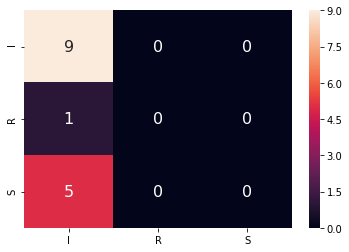

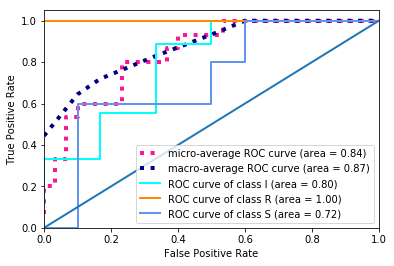


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.60      1.00      0.75         9
          R       0.00      0.00      0.00         1
          S       0.00      0.00      0.00         5

avg / total       0.36      0.60      0.45        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.61      1.00      0.75        20
          R       0.00      0.00      0.00         3
          S       0.00      0.00      0.00        10

avg / total       0.37      0.61      0.46        33



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [158]:
lr2 = train_logistic(X_diff, y_diff, True)

pickle.dump(lr2, open("lr_multi_model_diff.pkl", "wb") )

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warn

Best parameters set found on development set:

{'C': 0.001}

Grid scores on development set:

0.606 (+/-0.092) for {'C': 0.001}
0.545 (+/-0.212) for {'C': 0.01}
0.606 (+/-0.151) for {'C': 0.05}
0.606 (+/-0.240) for {'C': 0.1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



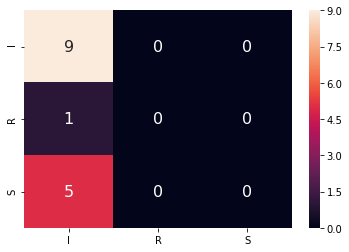

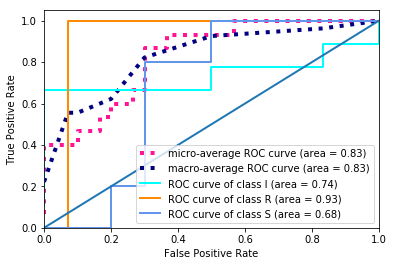


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.60      1.00      0.75         9
          R       0.00      0.00      0.00         1
          S       0.00      0.00      0.00         5

avg / total       0.36      0.60      0.45        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.61      1.00      0.75        20
          R       0.00      0.00      0.00         3
          S       0.00      0.00      0.00        10

avg / total       0.37      0.61      0.46        33



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [159]:
lr2 = train_logistic(X_concat, y_concat, True, cv=5)

pickle.dump(lr2, open("lr_multi_concat_model_diff.pkl", "wb") )

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

def train_bagging_DT(X,y, multiclass, cv=LeavePOut(3), test_size=0.3):
    #params = [{'n_estimators': [10,20, 50]}]
    model = BaggingClassifier(GradientBoostingClassifier(), n_estimators=7)

    results = model_selection.cross_val_score(model, X, y, cv=model_selection.KFold(n_splits=10))
    
    print(results.mean())                                          
    do_CV(X,y, model, multi_class=multiclass, test_size=test_size)
    return model

0.535
# Tuning hyper-parameter

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



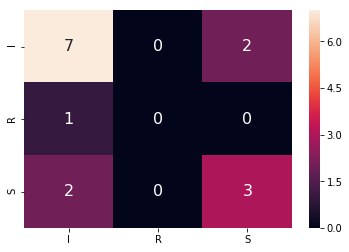

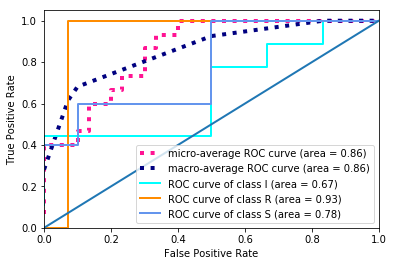


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.70      0.78      0.74         9
          R       0.00      0.00      0.00         1
          S       0.60      0.60      0.60         5

avg / total       0.62      0.67      0.64        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.95      1.00      0.98        20
          R       1.00      1.00      1.00         3
          S       1.00      0.91      0.95        11

avg / total       0.97      0.97      0.97        34



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BaggingClassifier(base_estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [35]:
train_bagging_DT(X_reduced, y_reduced, True, cv=7, test_size=0.3)

0.39
# Tuning hyper-parameter

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



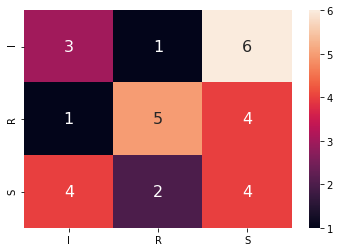

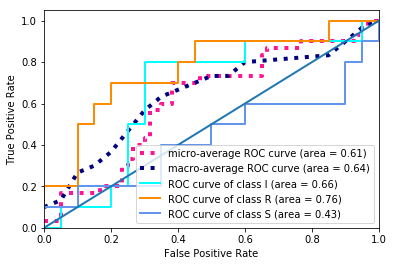


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.38      0.30      0.33        10
          R       0.62      0.50      0.56        10
          S       0.29      0.40      0.33        10

avg / total       0.43      0.40      0.41        30

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
          R       1.00      1.00      1.00        23
          S       1.00      1.00      1.00        22

avg / total       1.00      1.00      1.00        68



BaggingClassifier(base_estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [36]:
train_bagging_DT(X_reduced_aug, y_reduced_aug, True, cv=7, test_size=0.3) # BAD MODEL!

### GDA

In [13]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
def train_gaussian(X,y, multiclass, cv=5, test_size=0.3, scoring="accuracy"):
    # ALWAYS use regularization because of small data
    params = [{'reg_param': [0.1, 1, 10]}]
    lr = GridSearchCV(QuadraticDiscriminantAnalysis(), cv=cv, param_grid = params, scoring=scoring)
    utils.do_CV(X,y, lr, multi_class=multiclass, test_size=test_size)
    return lr.best_estimator_

# Tuning hyper-parameter

Best parameters set found on development set:

{'reg_param': 0.1}

Grid scores on development set:

0.732 (+/-0.265) for {'reg_param': 0.1}
0.643 (+/-0.174) for {'reg_param': 1}
0.411 (+/-0.016) for {'reg_param': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py

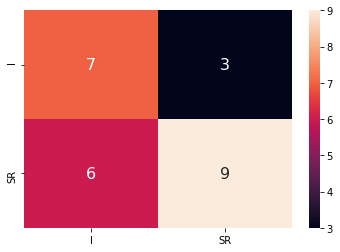

ROC AUC score
0.713333333333


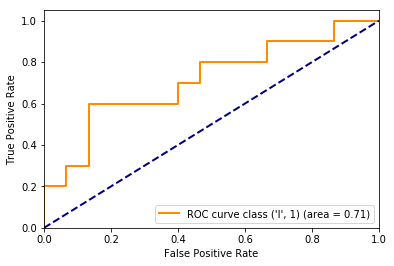


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.54      0.70      0.61        10
          SR       0.75      0.60      0.67        15

   micro avg       0.64      0.64      0.64        25
   macro avg       0.64      0.65      0.64        25
weighted avg       0.67      0.64      0.64        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.77      0.74      0.76        23
          SR       0.82      0.85      0.84        33

   micro avg       0.80      0.80      0.80        56
   macro avg       0.80      0.79      0.80        56
weighted avg       0.80      0.80      0.80        56



In [30]:
# Create correlation matrix
corr_matrix = X_reduced_aug2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

res = X_reduced_aug2.drop(X_reduced_aug2.columns[to_drop], axis=1)
lr2 = train_gaussian(res, y_reduced_aug2, False, cv=5, test_size=0.3)#, scoring=f1_multi_scorer)
#pickle.dump(lr2, open("lr2_binary_norm_reduced_model_aug_f1.pkl", "wb") )

In [31]:
res.shape

(81, 371)

# Tuning hyper-parameter

Best parameters set found on development set:

{'reg_param': 0.1}

Grid scores on development set:

0.643 (+/-0.449) for {'reg_param': 0.1}
0.464 (+/-0.264) for {'reg_param': 1}
0.411 (+/-0.035) for {'reg_param': 10}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py

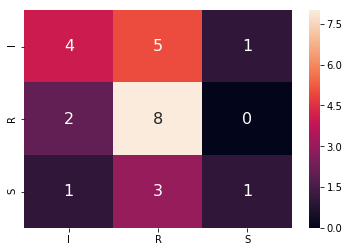

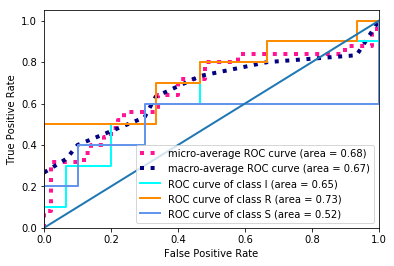


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.57      0.40      0.47        10
           R       0.50      0.80      0.62        10
           S       0.50      0.20      0.29         5

   micro avg       0.52      0.52      0.52        25
   macro avg       0.52      0.47      0.46        25
weighted avg       0.53      0.52      0.49        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.11      0.04      0.06        23
           R       0.47      0.39      0.43        23
           S       0.07      0.20      0.11        10

   micro avg       0.21      0.21      0.21        56
   macro avg       0.22      0.21      0.20        56
weighted avg       0.25      0.21      0.22        56



In [33]:
# Create correlation matrix
corr_matrix = X_reduced_aug2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

res = X_reduced_aug2.drop(X_reduced_aug2.columns[to_drop], axis=1)
lr2 = train_gaussian(res, y_reduced_aug2, True, cv=6, test_size=0.3)#, scoring=f1_multi_scorer)
#pickle.dump(lr2, open("lr2_binary_norm_reduced_model_aug_f1.pkl", "wb") )

### SVM: Note that these all just give 100% improved

In [8]:
params = [{'C': [0.1,10,100, 1000], 'gamma': [0.1,1,10,100, 1000]}]
sv = GridSearchCV(svm.SVC(), cv=lpo, param_grid = params)
utils.do_CV(X,y, sv, multi_class=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.1, 'gamma': 0.1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 10}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 100}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 10, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 10}
0.555 (+/-0.557) for {'C': 10, 'gamma': 100}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 100, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 10}
0.555 (+/-0.557) for {'C': 100, 'gamma': 100}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 10}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 100}
0.555

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.1, 'gamma': 0.1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 10}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 100}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 10, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 10}
0.555 (+/-0.557) for {'C': 10, 'gamma': 100}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 100, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 10}
0.555 (+/-0.557) for {'C': 100, 'gamma': 100}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 10}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 100}
0.555

/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


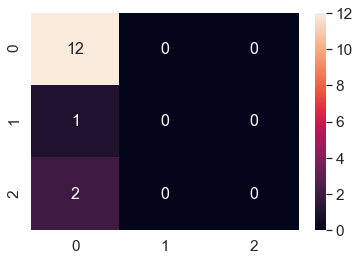

In [74]:
params = [{'C': [0.1,10,100, 1000], 'gamma': [0.1,1,10,100, 1000]}]
sv = GridSearchCV(svm.SVC(), cv=lpo, param_grid = params)
utils.do_CV(X,y, sv, multi_class=True)

### This can be ignored for now

In [7]:
def plot_learning_curve(model, X,y, cv):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y,
                                                            train_sizes=[5,10,15,20,25,30,35,40,45,48],
                                                            cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

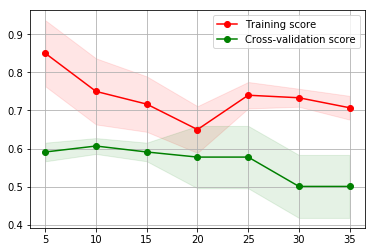

In [49]:
plot_learning_curve(knn, X,y, 4)

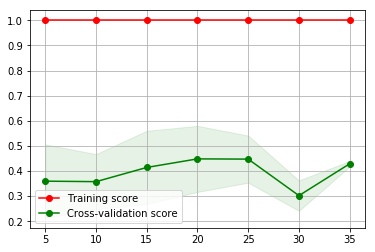

In [51]:
plot_learning_curve(logistic, X,y, 3)

In [ ]:
#pytorch
#pretrained embeddings
# extract a feature vector for any image with pytorch

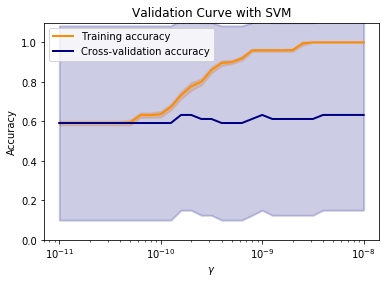

In [5]:
loo = model_selection.LeaveOneOut()
param_range = np.logspace(-11, -8, 31)

utils.generate_validation_curve(svm.SVC(), X, y, param_name="gamma", param_range=param_range,
                                cv=loo, scoring="accuracy", n_jobs=-1,
                                title="Validation Curve with SVM", xlabel="$\gamma$")

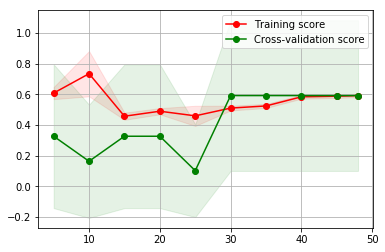

In [8]:
svm_classifier = svm.SVC(gamma=1e-11)
plot_learning_curve(svm_classifier, X,y, cv=loo)

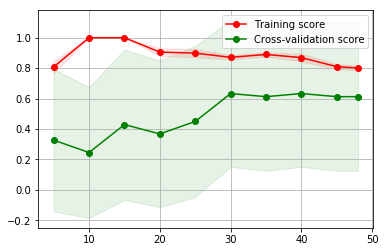

In [9]:
svm_classifier = svm.SVC(gamma=2.51188643e-10)
plot_learning_curve(svm_classifier, X,y, cv=loo)

In [140]:
plot_learning_curve(knn_model, X,y, cv=5)

NameError: name 'plot_learning_curve' is not defined